# Import the Libraries

In [218]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import exposure
from skimage import feature

from pandas import read_excel

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score


## HOG Feature Extraction

In [219]:
from IPython.display import clear_output

def get_feature_vector(image_directory, grid_q= 4, orientation= 8):
    img= cv2.imread(image_directory, cv2.IMREAD_GRAYSCALE)
    edges= cv2.Canny(img, 50, 200)

    hog_features = hog(img, orientations= orientation, pixels_per_cell= (int(img.shape[0]/grid_q), int(img.shape[1]/grid_q)),
                    cells_per_block=(1, 1), feature_vector= True)

    return hog_features


feature_matrix= []
for i in range(1, 1000):
    img_dir= "./pictures/" + str(i) + ".png"
    try:
        feature_vec= get_feature_vector(img_dir, grid_q= 3, orientation= 8)
        feature_matrix.append(feature_vec)
    except:
        pass

clear_output()
feature_matrix= np.array(feature_matrix)

print(feature_matrix.shape)
print(sum(sum(feature_matrix== 0))/feature_matrix.size)

(786, 72)
0.013411789652247668


### Scale & PCA

In [220]:
pca= PCA()
principal_components= pca.fit_transform(feature_matrix)
required_variance= .9
no_components= sum(pca.explained_variance_ratio_.cumsum() < required_variance) + 1

pca_var= PCA(no_components)
principal_matrix= pca_var.fit_transform(feature_matrix)

with open("labels.csv") as f:
    l= f.read()
    try: # Mac
        int(l[1:2])
        l= l[1:]
    except: # Windows
        l= l[3:]
    
    labels= np.array(l.split(), dtype= int)

nonzero_index= labels!= 0
labels= labels[nonzero_index]
principal_matrix= principal_matrix[nonzero_index]
print(principal_matrix.shape)


(786, 36)


### Support Vector Regressor & Hyperparameter Tuning

In [221]:
X_train, X_test, y_train, y_test= train_test_split(principal_matrix, labels, test_size= .2, random_state= 0)
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

svr= SVR()

param_grid= [
  {"kernel": ["linear"], "C": [.1, 1, 10, 100]},
  {"kernel": ["rbf"], "C": [1, 10, 100, 1000], "gamma": [1, .1, .01, .001]}
 ]

param_grid= [
  {"kernel": ["rbf"], "C": [100], "gamma": [.01]}
 ]

model= GridSearchCV(svr, param_grid= param_grid, verbose= True)

model.fit(X_train, y_train)
print(model.best_params_)
# print(model.cv_results_)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


In [222]:
y_pred= model.predict(X_test)

mae= mean_absolute_error(y_test, y_pred)

r2= r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

Mean Absolute Error: 33.308599228357444
R^2 Score: 0.14990264507581974


(0.0, 180.0, 0.0, 180.0)

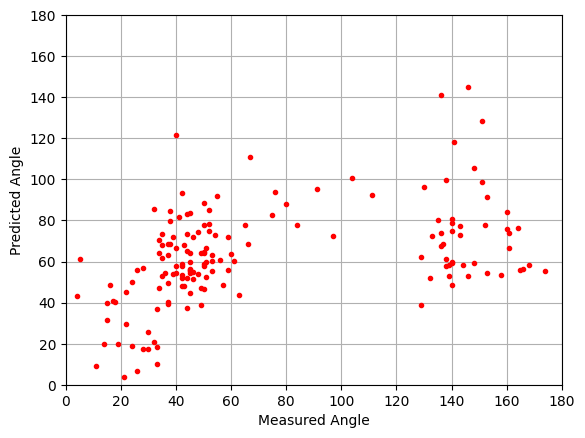

In [223]:
plt.plot(y_test, y_pred, "r.")
plt.grid()
plt.xlabel("Measured Angle")
plt.ylabel("Predicted Angle")
plt.axis([0, 180, 0, 180])

Text(0, 0.5, 'Count')

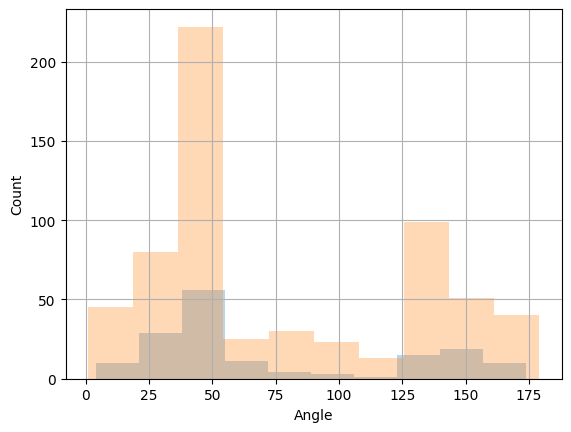

In [224]:
plt.hist(y_test, alpha= .3)
plt.hist(y_train, alpha= .3)

plt.grid()
plt.xlabel("Angle")
plt.ylabel("Count")